In [1]:
import numpy as np
np.random.seed(0)
import gym
env = gym.make('MountainCar-v0')
# 限制最多200步，unwrapped这一行注释
# env = env.unwrapped
env.seed(0)
print('观测空间 = {}'.format(env.observation_space))
print('动作空间 = {}'.format(env.action_space))
print('位置范围 = {}'.format((env.unwrapped.min_position, env.unwrapped.max_position)))
print('速度范围 = {}'.format((-env.unwrapped.max_speed,env.unwrapped.max_speed)))
print('目标位置 = {}'.format(env.unwrapped.goal_position))

观测空间 = Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
动作空间 = Discrete(3)
位置范围 = (-1.2, 0.6)
速度范围 = (-0.07, 0.07)
目标位置 = 0.5


失败退出


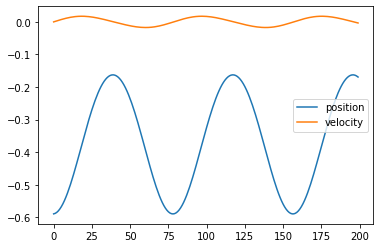

In [2]:
import matplotlib.pyplot as plt
positions, velocities = [], []
observation = env.reset()
while True:
    positions.append(observation[0])
    velocities.append(observation[1])
    next_observation, reward, done, _ = env.step(2)
    if done:
        break
    observation = next_observation

if next_observation[0] > 0.5:
    print('成功到达')
else:
    print('失败退出')

# 绘制位置和速度图像
fig, ax = plt.subplots()
ax.plot(positions, label='position')
ax.plot(velocities, label='velocity')
ax.legend()

In [3]:
import pandas as pd

# 经历库
class DQNReplayer:
    def __init__(self, capacity):
        '''

        :param capacity: 经历库的大小
        '''
        self.memory = pd.DataFrame(index=range(capacity),columns=['observation', 'action', 'reward','next_observation', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in self.memory.columns)

In [4]:
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow import keras

class DQNAgent:
    def __init__(self, env, net_kwargs={}, gamma=0.99, epsilon=0.001,replayer_capacity=10000, batch_size=64):
        '''

        :param env: 环境
        :param net_kwargs:
        :param gamma: 折扣因子
        :param epsilon: epsilon贪心策略
        :param replayer_capacity: 经历库的大小
        :param batch_size: batch
        '''
        observation_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon

        self.batch_size = batch_size
        # 经历回放
        self.replayer = DQNReplayer(replayer_capacity)
        # 评估网络
        self.evaluate_net = self.build_network(input_size=observation_dim,output_size=self.action_n, **net_kwargs)
        # 目标网络
        self.target_net = self.build_network(input_size=observation_dim,output_size=self.action_n, **net_kwargs)

        self.target_net.set_weights(self.evaluate_net.get_weights())

    # 构建网络
    def build_network(self, input_size, hidden_sizes, output_size,activation=tf.nn.relu, output_activation=None,learning_rate=0.01):
        model = keras.Sequential()
        for layer, hidden_size in enumerate(hidden_sizes):
            kwargs = dict(input_shape=(input_size,)) if not layer else {}
            model.add(keras.layers.Dense(units=hidden_size,activation=activation, **kwargs))
        model.add(keras.layers.Dense(units=output_size,activation=output_activation)) # 输出层
        optimizer = tf.optimizers.Adam(lr=learning_rate)
        model.compile(loss='mse', optimizer=optimizer)
        return model

    def learn(self, observation, action, reward, next_observation, done):
        # 存储经验
        self.replayer.store(observation, action, reward, next_observation,done)
        # 经验回放
        observations, actions, rewards, next_observations, dones = self.replayer.sample(self.batch_size)
        next_qs = self.target_net.predict(next_observations)
        next_max_qs = next_qs.max(axis=-1)
        us = rewards + self.gamma * (1. - dones) * next_max_qs
        targets = self.evaluate_net.predict(observations)
        targets[np.arange(us.shape[0]), actions] = us
        self.evaluate_net.fit(observations, targets, verbose=0)

        if done: # 更新目标网络
            self.target_net.set_weights(self.evaluate_net.get_weights())

    # epsilon贪心策略
    def decide(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_n)
        qs = self.evaluate_net.predict(observation[np.newaxis])
        return np.argmax(qs)

In [5]:

def play_qlearning(env, agent, train=False, render=False):
    print('play_qlearning')
    episode_reward = 0
    observation = env.reset()
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done)
        if done:
            break
        observation = next_observation
    return episode_reward

In [ ]:
net_kwargs = {'hidden_sizes' : [64, 64], 'learning_rate' : 0.001}
agent = DQNAgent(env, net_kwargs=net_kwargs)

# 训练
episodes = 500
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
    print('{}  {}'.format(episode,episode_reward))

play_qlearning
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFl

In [ ]:
# 测试
agent.epsilon = 0. # 取消探索
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),len(episode_rewards), np.mean(episode_rewards)))

In [ ]:
class DoubleDQNAgent(DQNAgent):
    def learn(self, observation, action, reward, next_observation, done):
        self.replayer.store(observation, action, reward, next_observation,done) # 存储经验
        observations, actions, rewards, next_observations, dones = self.replayer.sample(self.batch_size) # 经验回放
        next_eval_qs = self.evaluate_net.predict(next_observations)
        next_actions = next_eval_qs.argmax(axis=-1)
        next_qs = self.target_net.predict(next_observations)
        next_max_qs = next_qs[np.arange(next_qs.shape[0]), next_actions]
        us = rewards + self.gamma * next_max_qs * (1. - dones)
        targets = self.evaluate_net.predict(observations)
        targets[np.arange(us.shape[0]), actions] = us
        self.evaluate_net.fit(observations, targets, verbose=0)

        if done:
            self.target_net.set_weights(self.evaluate_net.get_weights())

In [ ]:
net_kwargs = {'hidden_sizes' : [64, 64], 'learning_rate' : 0.001}
agent = DoubleDQNAgent(env, net_kwargs=net_kwargs)

# 训练
episodes = 500
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
    print('{}  {}'.format(episode,episode_reward))


In [ ]:
# 测试
agent.epsilon = 0. # 取消探索
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),len(episode_rewards), np.mean(episode_rewards)))
